In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
PHONE_TABLE = """
sil spn 
a aj aw 
o ow
ə ɥ 
e ej  
i io
j w u y
p pʰ m f
t tʰ n l
k kʰ x 
tɕ tɕʰ  
ʈʂ ʈʂʰ ʂ ʐ ʐ̩
ts tsʰ ɕ
z z̩ s 
ŋ ŋ̍ ɻ ʔ
"""
phone_table = PHONE_TABLE.strip().replace("\n", " ").split()

## Data dependencies

In [3]:
rzs_var_path = "../../data/fst/xianzai_rzs_var.json"
ali_var_path = "../../data/fst/ali_var.txt"
loglik_path = "../../data/fst/xianzai_phone_loglik.ark"
!sha1sum $rzs_var_path $ali_var_path $loglik_path

197e24220f96e16c18009e3038129406178231a0  ../../data/fst/xianzai_rzs_var.json
333d79d167452877745415e8b980c5764fc6e060  ../../data/fst/ali_var.txt
9259328dbacdb2557e03fdfd5b3f12f91d583b5b  ../../data/fst/xianzai_phone_loglik.ark


## Load Data

In [4]:
import json
from typing import cast, Dict
from pathlib import Path
import numpy as np
from kaldiio import load_ark
from tqdm.auto import tqdm

rzs_var = dict(json.load(Path(rzs_var_path).open()))
ali_map = [x.split() for x 
           in Path(ali_var_path).read_text().splitlines()]
ali_map = {x[0]: np.array([int(x) for x in x[1:]]) 
           for x in ali_map}
ali_map = cast(Dict[str, np.ndarray], ali_map)
lgmmprob_map = {x[0]: x[1] for x in load_ark(loglik_path)}
lgmmprob_map = cast(Dict[str, np.ndarray], lgmmprob_map)

## Post processing

In [5]:
post_ali_idxs = {}
for utt_id in ali_map.keys():
    # if utt_id != "YQY_GY_0216": continue
    ali_idxs = ali_map[utt_id]   
    lgmmprob = lgmmprob_map[utt_id]
    assert len(ali_idxs) == lgmmprob.shape[0]
    # check if there is only one isloated index in the sequence
    cur_cumulator = 0
    # print("original: ", ali_idxs)
    new_idxs = []
    for t, (aidx_0, aidx_1) in enumerate(zip(ali_idxs, ali_idxs[1:])):
        if aidx_0 != aidx_1 and cur_cumulator == 0:
            # isolated index found    
            # print("isolated: ", aidx_0)
            # compare the logliks of the prev and next states
            if t == 0:
                # this is the first index, just replace with the next one
                new_idxs.append(aidx_1)
            else:
                prev_aidx = ali_idxs[t-1]   
                next_aidx = ali_idxs[t+1]   # we will always have a next index
                # print(f"t={t}", "prev/next aidx", prev_aidx, next_aidx)
                # print(lgmmprob[t, prev_aidx], lgmmprob[t, next_aidx])
                # notice ali_idx is 1-based
                if lgmmprob[t, prev_aidx-1] > lgmmprob[t, next_aidx-1]:  # type:ignore
                    new_idxs.append(prev_aidx)                    
                else:
                    new_idxs.append(next_aidx)                
        elif aidx_0 != aidx_1 and cur_cumulator > 0:
            # new aidx encountered
            cur_cumulator = 0            
            # print("new: ", aidx_0)
            new_idxs.append(aidx_0)
        else:
            cur_cumulator += 1
            new_idxs.append(aidx_0)

    ## handle the last index
    if ali_idxs[-1] != ali_idxs[-2]:
        # this is the last index, just replace with the previous one
        new_idxs.append(ali_idxs[-2])
    else:
        new_idxs.append(ali_idxs[-1])
        
    new_idxs = np.array(new_idxs)
    # print("post: ", new_idxs)
    post_ali_idxs[utt_id] = new_idxs

In [6]:
def build_rzs(ali_map):
  realized_phones = {}
  for utt_id, ali_seq in ali_map.items():    
    ali_phones = [phone_table[x-1] for x in ali_seq]
    dedup = []
    for x in ali_phones:
      if not dedup:
        dedup.append(x)
        continue
      if x != dedup[-1]:
        dedup.append(x)
    if ali_phones[-1] != dedup[-1]:
      dedup.append(ali_phones[-1])
    dedup = " ".join(dedup)
    realized_phones.setdefault(dedup, []).append(utt_id)
  return realized_phones
post_rzs = build_rzs(post_ali_idxs)
common_rzs = sorted(post_rzs.items(), key=lambda x: len(x[1]), reverse=True)[:10]
for rz_x, utt_ids in common_rzs:
  print(rz_x, ":", len(utt_ids))


ɕ e n ts aj : 290
ɕ e n aj : 73
ɕ e aj : 68
ɕ e n a : 41
ɕ e n ts a : 40
ɕ e n : 39
ɕ e a : 37
ɕ e ts aj : 23
ɕ j a : 22
ɕ j a aj : 19


Text(0.5, 1.0, 'Common variants of xianzai')

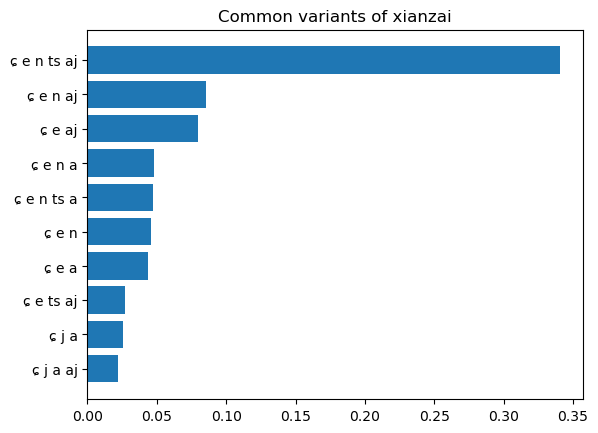

In [19]:
import matplotlib.pyplot as plt
plt.barh(
    y=[x[0] for x in common_rzs[::-1]],
    width=[len(x[1])/len(ali_map) for x in common_rzs[::-1]],
    )
plt.title("Common variants of xianzai")

## Decoded

Text(0.5, 1.0, 'Decoded XHR_GY_4707')

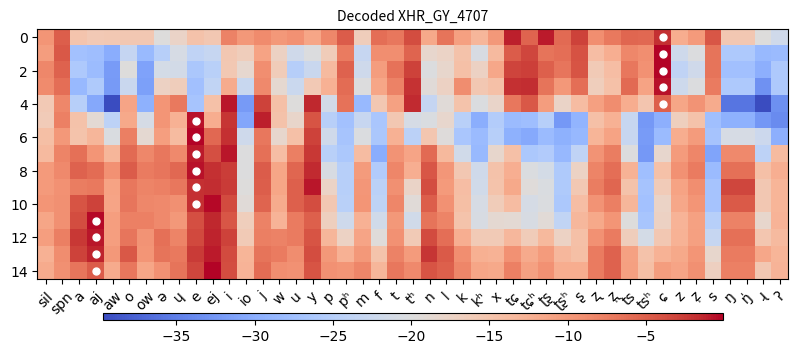

In [61]:
tgt_utt_id = post_rzs["ɕ e aj"][3]
pmat = lgmmprob_map[tgt_utt_id]
ali_ints = post_ali_idxs[tgt_utt_id]
fig = plt.figure(figsize=(10, 10*(pmat.shape[0]/pmat.shape[1])+1))
plt.imshow(pmat, cmap="coolwarm")

xticks = range(0, len(phone_table), 1)
xticklabels = [phone_table[y] for y in xticks]
plt.plot(ali_ints-1, np.arange(len(ali_ints)), color="white", ms=5, marker="o", ls="none")
plt.xticks(xticks, xticklabels, rotation=45) 
plt.colorbar(location="bottom", aspect=80, shrink=0.8, pad=0.1)
plt.title(f"Decoded {tgt_utt_id}", fontsize=20, font="Noto Sans CJK JP")
# fig.savefig(str(fig_dir/f"{utt_x.utt_id}_{word_x.label}.png"))

In [58]:
from pathlib import Path
from IPython.display import Audio
wav_dir = Path(f"~/lago/mfa_data/xianzai/s1/").expanduser()
Audio(wav_dir/f"{tgt_utt_id}.wav", rate=22050)

## Greedy decoding

Text(0.5, 1.0, 'Decoded XHR_GY_4707')

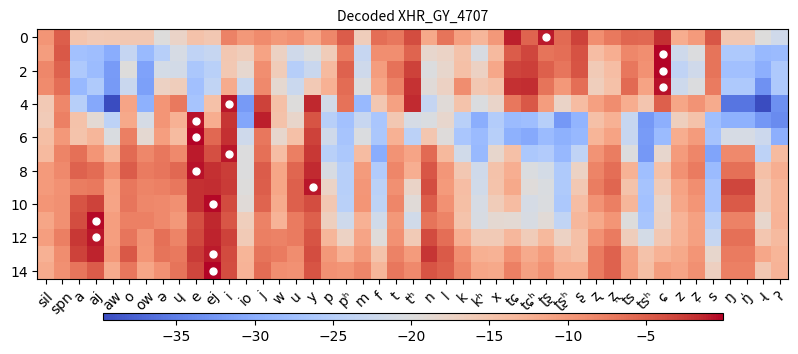

In [60]:
import matplotlib.pyplot as plt

pmat = lgmmprob_map[tgt_utt_id]
greedy_ints = pmat.argmax(axis=1)
fig = plt.figure(figsize=(10, 10*(pmat.shape[0]/pmat.shape[1])+1))
plt.imshow(pmat, cmap="coolwarm")

xticks = range(0, len(phone_table), 1)
xticklabels = [phone_table[y] for y in xticks]
plt.plot(greedy_ints, np.arange(len(greedy_ints)), color="white", ms=5, marker="o", ls="none")
plt.xticks(xticks, xticklabels, rotation=45) 
plt.colorbar(location="bottom", aspect=80, shrink=0.8, pad=0.1)
plt.title(f"Decoded {tgt_utt_id}", fontsize=20, font="Noto Sans CJK JP")
# fig.savefig(str(fig_dir/f"{utt_x.utt_id}_{word_x.label}.png"))

## Clustering

In [65]:
from scipy.interpolate import interp1d
lgmm_intp_map = {}
nstep = 20
for utt_id, pmat in lgmmprob_map.items():
    intp = interp1d(np.arange(pmat.shape[0]), pmat, axis=0, kind="linear")
    lgmm_intp_map[utt_id] = intp((np.arange(nstep)/nstep) * (pmat.shape[0]-1))

lgmm_vec_X.shape (609, 900)


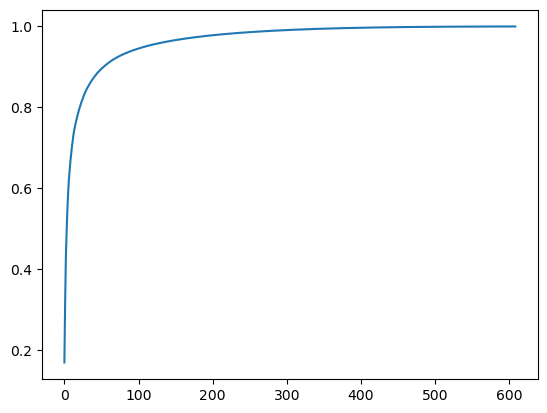

In [66]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

rzs_map = {}
visX = []
visY = []
for rzs_x, utt_id_list in post_rzs.items():  
  if len(utt_id_list) < 20:
    continue
  visX.extend([lgmm_intp_map[x].flatten() for x in utt_id_list])
  visY.extend([rzs_x]*len(utt_id_list))

lgmm_vec_X = np.vstack([visX])
print("lgmm_vec_X.shape", lgmm_vec_X.shape)
pca = PCA().fit(lgmm_vec_X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [67]:
import seaborn as sns
tsne = TSNE(metric="cosine")
lgmm_pca_X = PCA(n_components=300).fit_transform(lgmm_vec_X)
lgmm_tsne_X = tsne.fit_transform(lgmm_pca_X)

<Axes: >

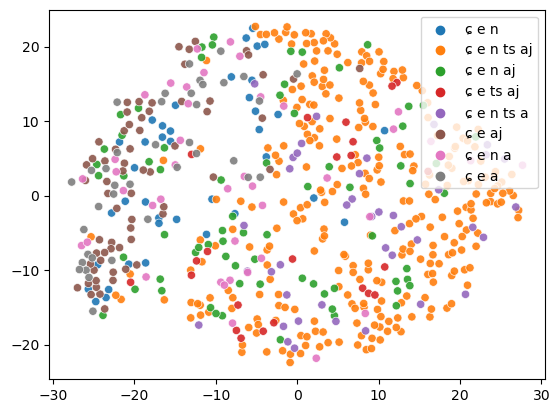

In [68]:

sns.scatterplot(x=lgmm_tsne_X[:, 0], y=lgmm_tsne_X[:, 1], hue=visY, alpha=0.9)

Train acc:  0.9938398357289527
Test acc:  0.5573770491803278
Majority baseline:  0.5737704918032787


<Axes: >

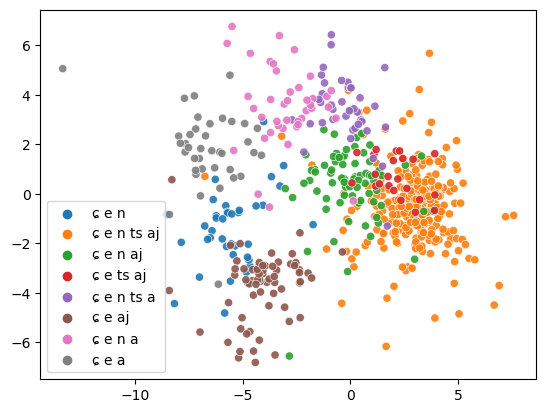

In [76]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(lgmm_pca_X, visY, test_size=0.2, random_state=42)
lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain, ytrain)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(Xtrain, ytrain)
print("Train acc: ", lda.score(Xtrain, ytrain))
print("Test acc: ", lda.score(Xtest, ytest))
print("Majority baseline: ", dummy.score(Xtest, ytest))
lda_proj = lda.transform(lgmm_pca_X)
sns.scatterplot(x=lda_proj[:, 0], y=lda_proj[:, 1], hue=visY, alpha=0.9)